In [53]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

import statsmodels.stats.api as sms

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment
from scipy import stats

from sklearn import metrics


from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [54]:
plt.style.use([{
    "figure.figsize":(12,9),
    "xtick.labelsize": "xx-small",
    "ytick.labelsize": "large",
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "xx-large",
    "axes.spines.top": False,
    "axes.spines.right": False,
},'bmh'])

In [55]:
def plot_correlogram(x, lags=None,residual = None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(2,2, figsize=(16, 10))
    axes[0,0].plot(x.index,x,'r:')
    axes[0,0].plot(x.rolling(21).mean(), c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0,0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    axes[0,0].tick_params(labelsize=12)
    axes[0,0].set_title(residual) 
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False,auto_ylims= True, ax=axes[1,0])
    plot_pacf(x=x, lags=lags, zero=False,auto_ylims= True, ax=axes[1,1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title,fontsize=20)
    sns.despine()
    fig.tight_layout()
    plt.subplots_adjust(left=0,right=1.3,
                    bottom=0,top=0.9,
                    wspace=0.08,hspace=0.25)

In [56]:
oil =  yf.Ticker('ETH-USD').history(period ='3mo',
                                  interval = '1h', 
                                 actions = True,auto_adjust = True)

oil.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-10-28 16:00:00+00:00,2498.451660,2513.256104,2498.451660,2503.792236,0,0.0,0.0
2024-10-28 17:00:00+00:00,2503.026855,2511.950439,2490.698730,2500.448242,564548608,0.0,0.0
2024-10-28 18:00:00+00:00,2499.512695,2509.574219,2492.360596,2502.772461,324843520,0.0,0.0
2024-10-28 19:00:00+00:00,2504.002197,2521.014404,2500.075195,2501.083252,1022665728,0.0,0.0
2024-10-28 20:00:00+00:00,2505.088135,2515.699951,2505.088135,2514.584229,287724544,0.0,0.0


In [57]:
return_oil        = np.log(oil.Close).diff().dropna().mul(100 )
squared_resid_oil = return_oil.sub(return_oil.mean()).pow(2) # rescale to faciliate optimization
train, test = return_oil[:-300],return_oil[-300:] 

train.shape

(1907,)

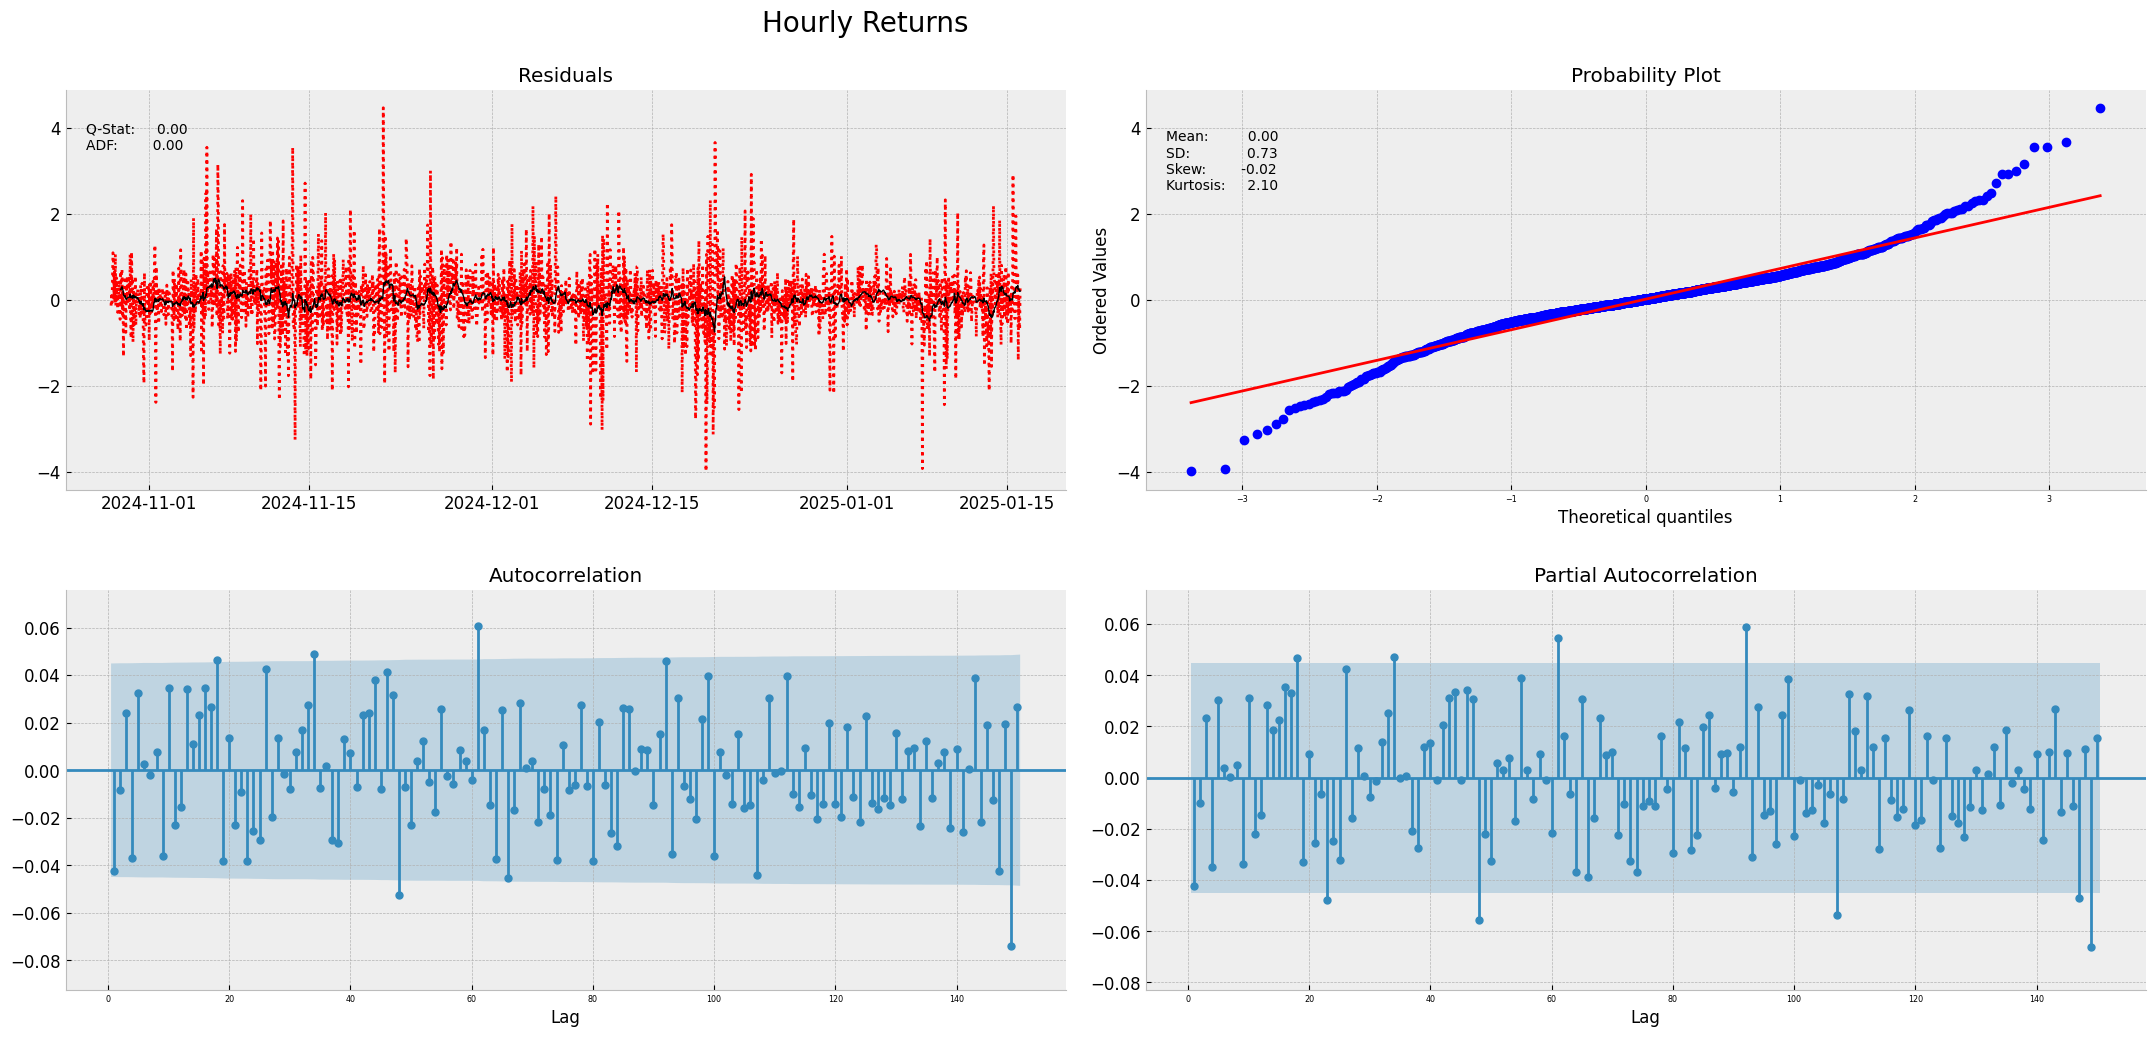

In [58]:
plot_correlogram(train, lags=150, residual = 'Residuals', title='Hourly Returns') 

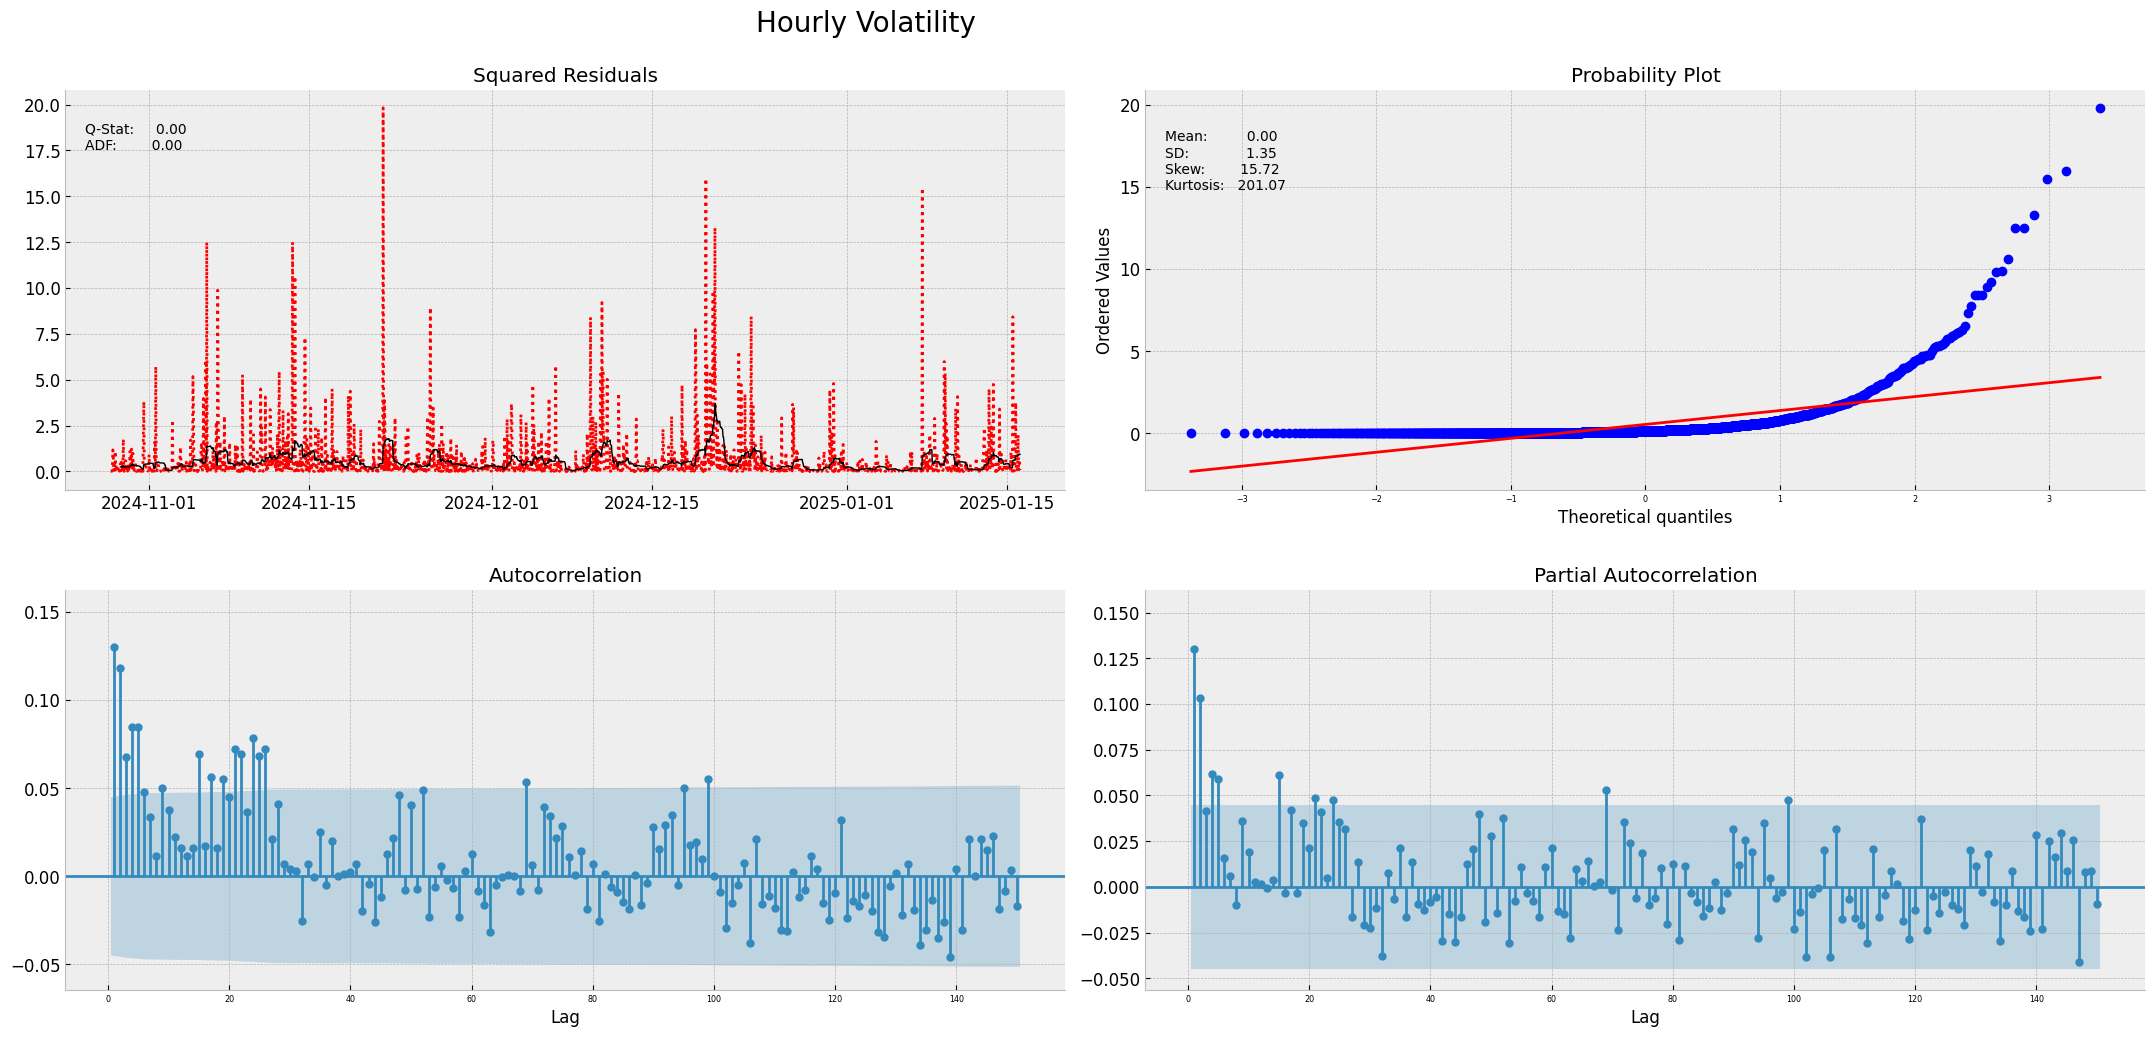

In [59]:
plot_correlogram(squared_resid_oil[:-300], lags=150, residual = 'Squared Residuals' , title='Hourly Volatility') 

In [60]:
dist = ['normal','StudentsT','skewt']
for i in dist:
  # fit GARCH model
  garch_model= arch_model(train , p =1, q=1, vol='GARCH', dist=i).fit(disp='off')
  print(garch_model)
  print('The sum of Alpha and Beta using {} is:{} '.format(i,sum(garch_model.params[2:4])))

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2031.34
Distribution:                  Normal   AIC:                           4070.69
Method:            Maximum Likelihood   BIC:                           4092.90
                                        No. Observations:                 1907
Date:                Tue, Jan 28 2025   Df Residuals:                     1906
Time:                        22:18:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0145  1.468e-02      0.990      0.322 

In [61]:
# fit garch(1,1) with Student's t-distribution
garch_oil = arch_model(train , p =1, q=1, vol='GARCH', dist='skewt').fit(disp='off')

In [62]:
def diagnistic_std_resid(x):
    
# Obtain model estimated residuals and volatility
  oil_garch_resid = x.resid
  oil_garch_std  = x.conditional_volatility

# Calculate the standardized residuals
  garch_std_resid = oil_garch_resid/oil_garch_std

# Plot the histogram of the standardized residuals
  plt.figure(figsize=(15,8))
  plt.hist(garch_std_resid, bins=50, density=True, histtype='bar', alpha=0.5)
  plt.hist(np.random.normal(loc=0, scale=1, size=len(garch_std_resid)), bins=50, density= True, histtype= 'step', alpha=1, color='r')
  plt.legend(('normal', 'standardized residuals'))
# Plot the correlogram
  plot_correlogram(garch_std_resid, lags=100,residual='Standardized Residuals', title='GARCH standard Residuals')
  plt.tick_params(labelsize=8)
  plt.show()

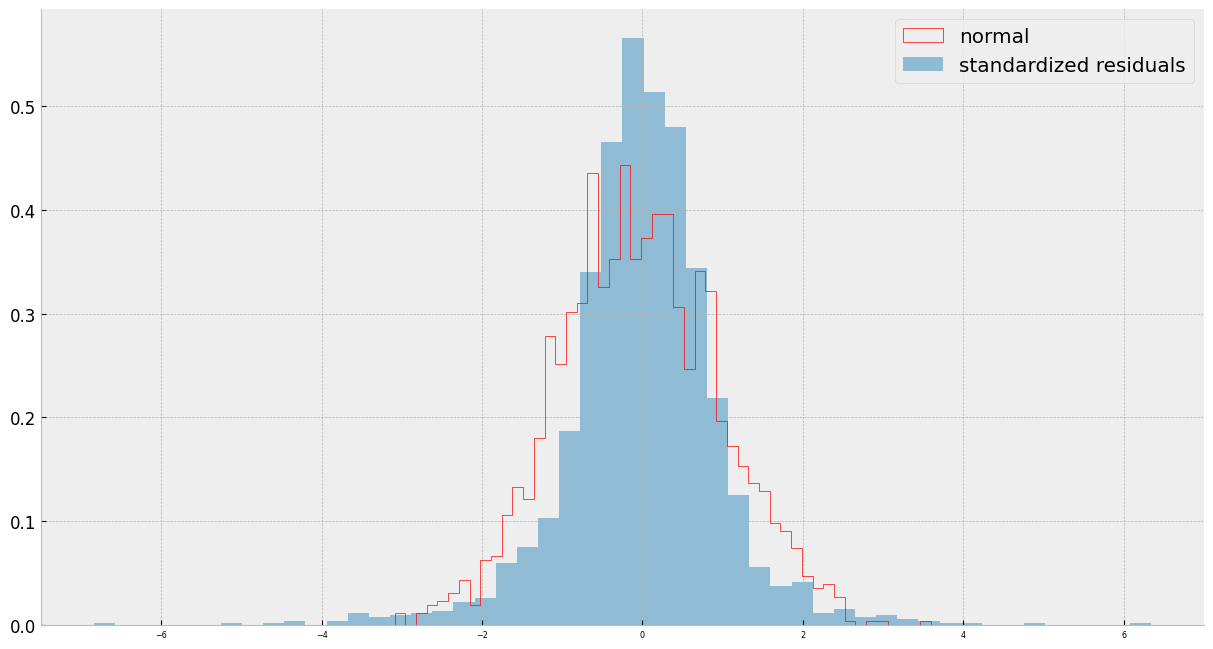

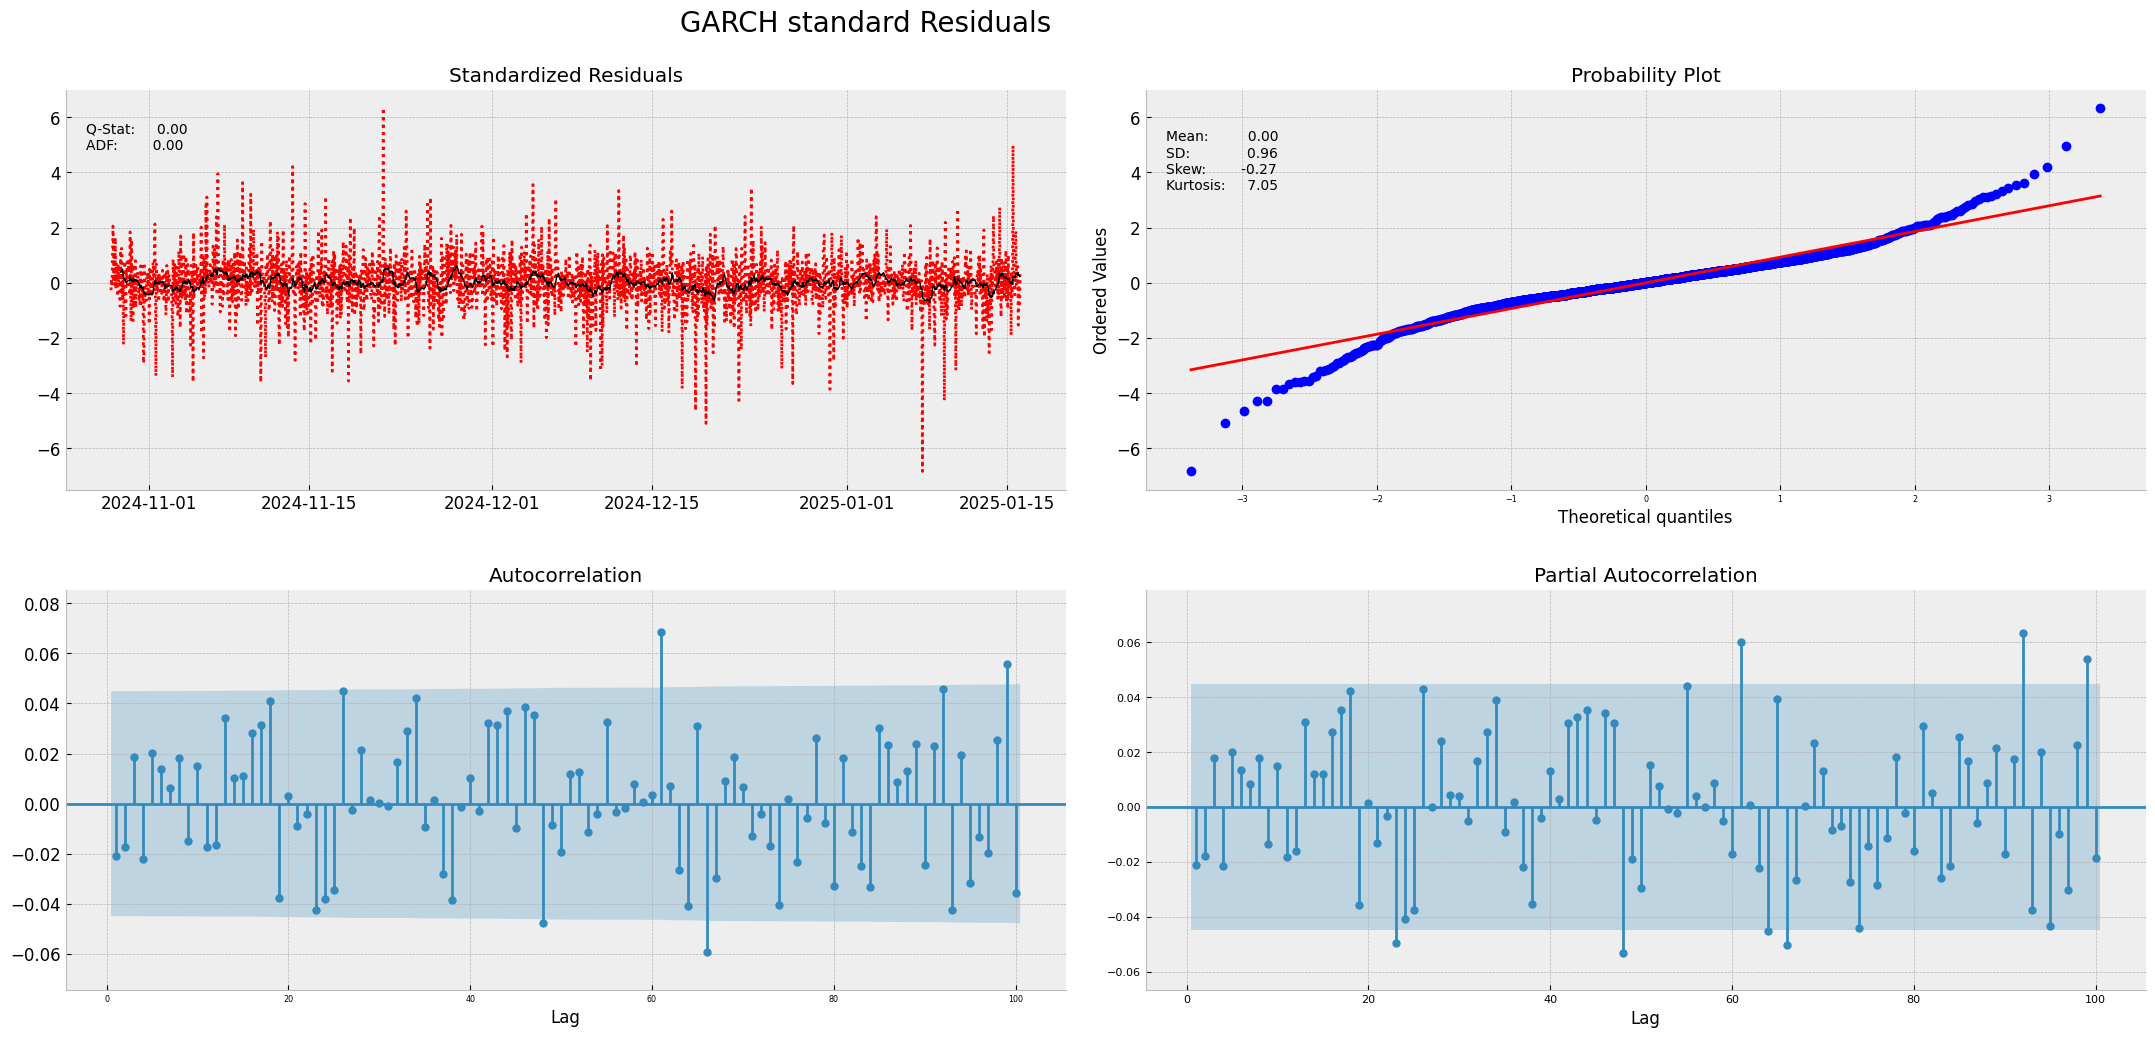

In [63]:
diagnistic_std_resid(garch_oil)

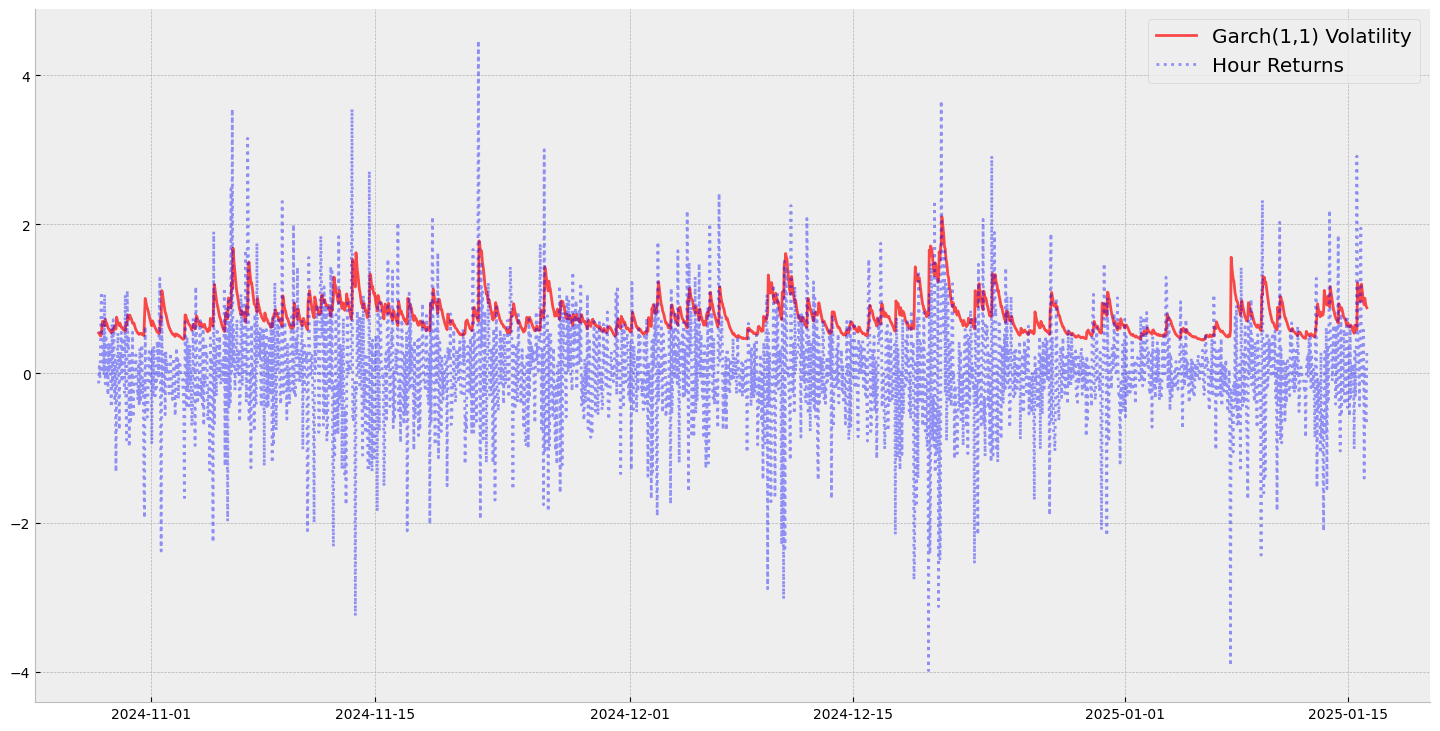

In [64]:
plt.figure(figsize=(18,9))
plt.plot(garch_oil.conditional_volatility, 'r-', label = 'Garch(1,1) Volatility',alpha=0.7)
plt.plot(train,'b:', label = 'Hour Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.tick_params(labelsize=10)
plt.show()

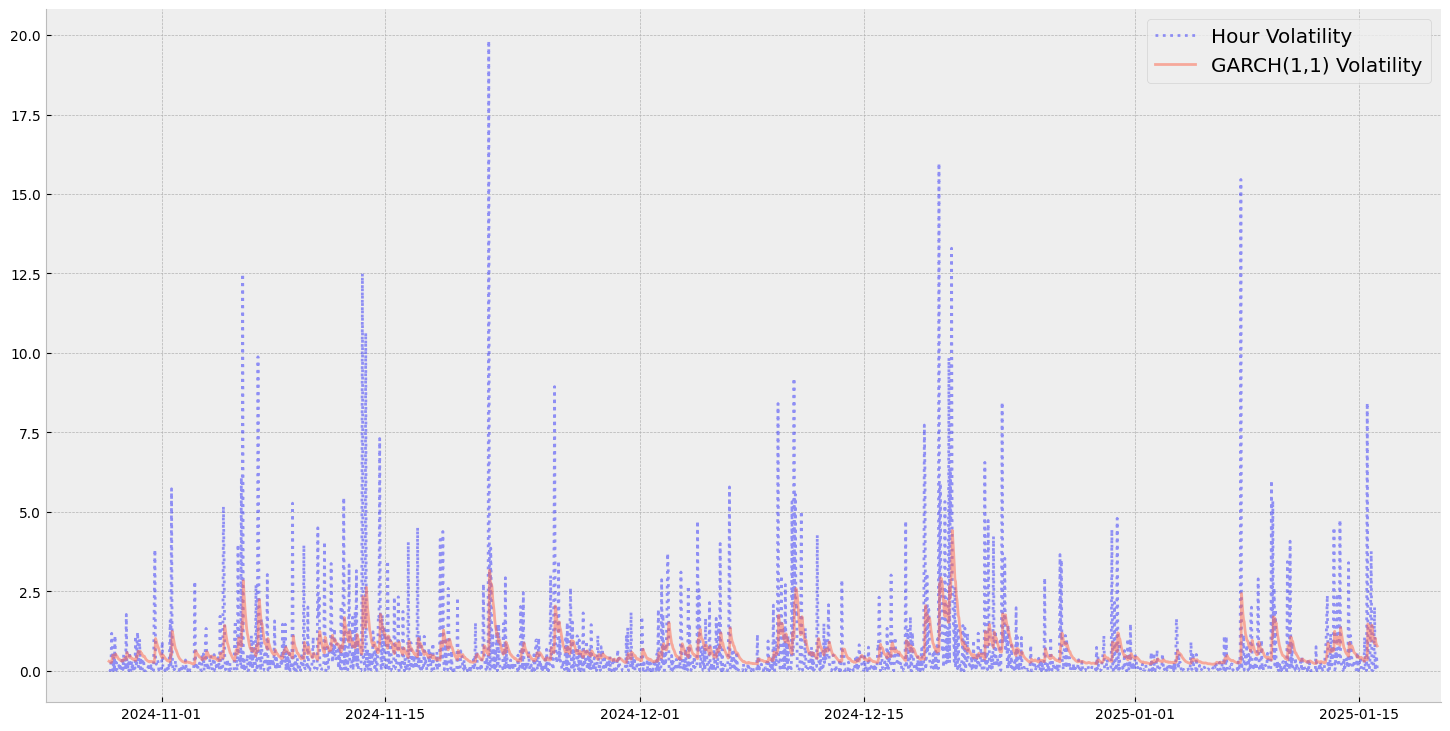

In [65]:
plt.figure(figsize=(18,9))
variance = squared_resid_oil[:-300]
plt.plot(variance, 'b:', alpha = 0.4, label = 'Hour Volatility')
# Plot GARCH  estimated volatility
plt.plot((garch_oil.conditional_volatility)**2,color='tomato', alpha=0.5, label = 'GARCH(1,1) Volatility')
plt.tick_params(labelsize=10)
plt.legend(loc = 'upper right')
plt.show()

In [66]:
df = pd.DataFrame()
df['true vol'] = squared_resid_oil[-300:-1]

# Implement Fixed rolling window forecast
expanding_rolling_forecast = []
for i in range(299):
  train         = return_oil[:-299+i]
  model         = arch_model(train, p=1,q=1,vol = 'GARCH', dist='skewt')
  model_fit     = model.fit(disp='off')
  model_predict =  model_fit.forecast(horizon=1).variance.values[-1:][0]
  expanding_rolling_forecast.append((model_predict))
df['expand window']= expanding_rolling_forecast

# Implement expanding window forecast
fixed_rolling_forecast = []
for i in range(299):
  train         = return_oil[i :-299+i]
  model         = arch_model(train,q=1,p=1,vol='GARCH',dist = 'skewt')
  model_fit     = model.fit(disp='off')
  model_predict = model_fit.forecast(horizon=1).variance.values[-1:][0]
  fixed_rolling_forecast.append((model_predict))
df['fixed window'] = fixed_rolling_forecast

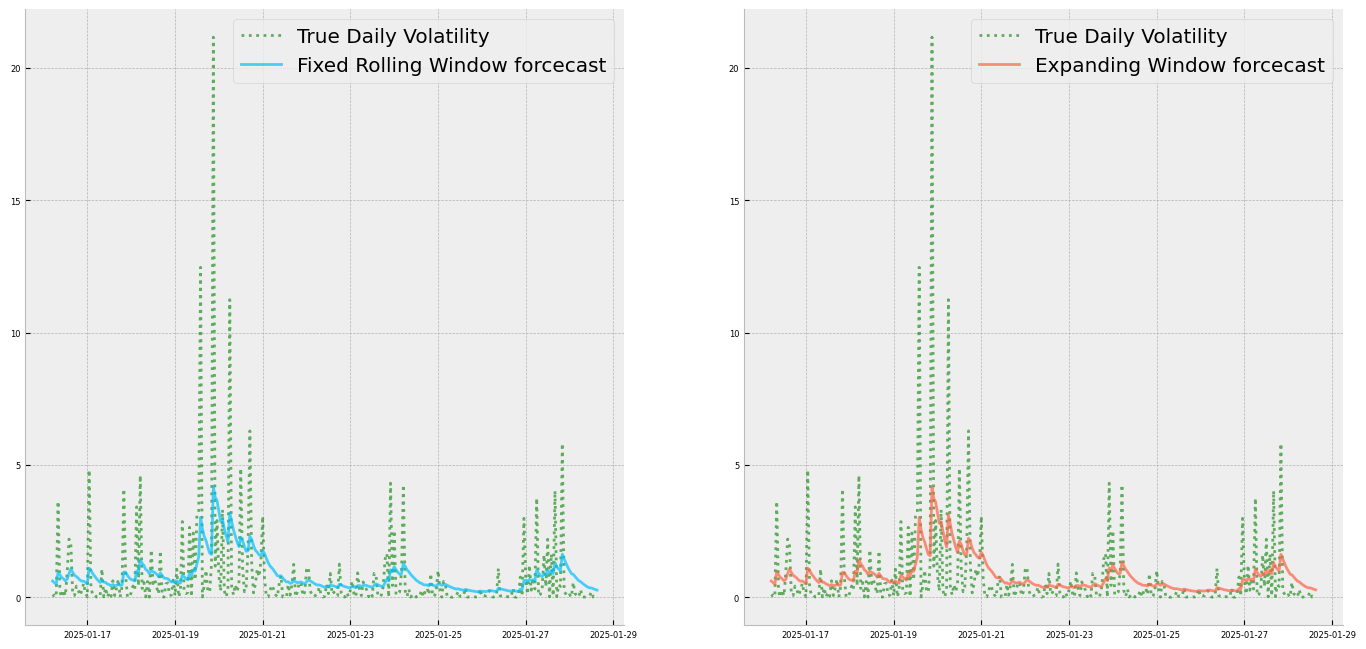

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(17,8))
axes[0].plot(df['true vol'],'g:', alpha = 0.6, label = 'True Daily Volatility')
axes[0].plot(df['fixed window'],color='deepskyblue',alpha=0.7, label = 'Fixed Rolling Window forcecast')
axes[0].tick_params(labelsize=6)
axes[0].legend(loc = 'upper right')
axes[1].plot(df['true vol'],'g:',alpha = 0.6, label = 'True Daily Volatility')
axes[1].plot(df['expand window'],color='tomato', alpha=0.7, label = 'Expanding Window forcecast')
plt.tick_params(labelsize=6)
plt.legend(loc = 'upper right')
plt.show()

In [68]:
def timeseries_evaluation_metrics_func(y_true, y_pred,forecast):
    print('Evaluation metric results of {}:'.format(forecast))
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
      
print(timeseries_evaluation_metrics_func(df['true vol'],df['fixed window'],'fixed forecast'))
print(timeseries_evaluation_metrics_func(df['true vol'],df['expand window'],'expanding forecast'))

Evaluation metric results of fixed forecast:
MSE is : 2.4831039842386393
RMSE is : 1.5757867826069107
None
Evaluation metric results of expanding forecast:
MSE is : 2.4550451511803115
RMSE is : 1.5668583698536098
None


In [69]:
# Create a dataframe for the strategy based on test data
oil_algo = oil[-df.index.shape[0]:]

# Calculating Bollinger Bands considering 20 hours and 2 standard deviations
oil_algo['Rolling Mean']     = oil_algo['Close'].rolling(20).mean()
oil_algo['Rolling std']      = oil_algo['Close'].rolling(20).std()
oil_algo['Bollinger High']   = oil_algo['Rolling Mean'] + (oil_algo['Rolling std']*2)
oil_algo['Bollinger Low']    = oil_algo['Rolling Mean'] - (oil_algo['Rolling std']*2)

# Using fixed forecast as garch volatility
df['fixed window']         = np.array(df['expand window'],dtype=float) 
oil_algo['Garch forecast'] = df['fixed window'] 

oil_algo.tail()

C:\Users\Arin Zingade\AppData\Local\Temp\ipykernel_25084\3539597654.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Arin Zingade\AppData\Local\Temp\ipykernel_25084\3539597654.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Arin Zingade\AppData\Local\Temp\ipykernel_25084\3539597654.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Rolling Mean,Rolling std,Bollinger High,Bollinger Low,Garch forecast
Datetime,,,,,,,,,,,,
2025-01-28 12:00:00+00:00,3186.939453,3195.152832,3168.450928,3173.530029,0,0.0,0.0,3167.544568,47.207772,3261.960112,3073.129023,0.352309
2025-01-28 13:00:00+00:00,3174.469238,3187.560547,3172.039795,3174.822510,0,0.0,0.0,3172.646216,41.610234,3255.866685,3089.425747,0.322678
2025-01-28 14:00:00+00:00,3174.670166,3177.160400,3159.303711,3176.334717,6465536,0.0,0.0,3178.859802,30.433653,3239.727108,3117.992496,0.297490
2025-01-28 15:00:00+00:00,3176.770020,3211.329346,3175.475830,3175.475830,780265472,0.0,0.0,3184.041504,17.197819,3218.437142,3149.645865,0.276106
2025-01-28 16:00:00+00:00,3181.534668,3181.534668,3156.285400,3162.552979,758384640,0.0,0.0,3184.812756,15.739295,3216.291347,3153.334166,NaN


In [70]:
# Plotting Bollinger Bands and GARCH forecast Volatility 
fig_bb = make_subplots(rows = 1, cols=2,horizontal_spacing=0.05)

fig_bb.add_trace(go.Scatter(x=oil_algo.index, y=oil_algo['Rolling Mean'], name='SMA_20'), row=1, col=1)
fig_bb.add_trace(go.Scatter(x=oil_algo.index, y=oil_algo.Close, name='Close'),row=1, col=1)
fig_bb.add_trace(go.Scatter(x=oil_algo.index, y=oil_algo['Bollinger High'] , name='Uper Band'),row=1, col=1)
fig_bb.add_trace(go.Scatter(x=oil_algo.index, y=oil_algo['Bollinger Low'], name='Low Band'),row=1, col=1)
fig_bb.add_trace(go.Scatter(x=oil_algo.index, y=oil_algo['Garch forecast'] , name='garch variance'), row=1, col=2)

fig_bb.update_layout(title='Price of crude Oil and Bollinger Bands',hovermode='x unified', height=700, showlegend=True,
                     width=1170, xaxis1=dict(domain=[0, 0.61]), xaxis2=dict(domain=[0.63,1]))


fig_bb.show()

In [76]:
oil_algo['Position BB'] = None

# Fill our newly created position column - set to sell (-1) when the price hits the upper band and next garch forecast is high,
#and set to buy (1) when it hits the lower band
for i in range(len(oil_algo)):
    
    if ((oil_algo['Close'].iloc[i] > oil_algo['Bollinger High'].iloc[i]) and 
       (oil_algo['Close'].iloc[i-1] < oil_algo['Bollinger High'].iloc[i-1]) and
        (oil_algo['Garch forecast'].iloc[i+1] > oil_algo['Garch forecast'].iloc[i]*1.2)): 
        oil_algo['Position BB'].iloc[i] = -1
        
    if ((oil_algo['Close'].iloc[i] > oil_algo['Bollinger High'].iloc[i]) and 
       (oil_algo['Close'].iloc[i-1] < oil_algo['Bollinger High'].iloc[i-1]) and
        (oil_algo['Garch forecast'].iloc[i+1] < oil_algo['Garch forecast'].iloc[i]*1.2)): 
        oil_algo['Position BB'].iloc[i] = 1
        
    if ((oil_algo['Close'].iloc[i] < oil_algo['Bollinger Low'].iloc[i]) and
       (oil_algo['Close'].iloc[i-1] > oil_algo['Bollinger Low'].iloc[i-1])and
       (oil_algo['Garch forecast'].iloc[i+1] > oil_algo['Garch forecast'].iloc[i]*1.2)): 
        oil_algo['Position BB'].iloc[i] = 1
        
    if ((oil_algo['Close'].iloc[i] < oil_algo['Bollinger Low'].iloc[i]) and
       (oil_algo['Close'].iloc[i-1] > oil_algo['Bollinger Low'].iloc[i-1])and
       (oil_algo['Garch forecast'].iloc[i+1] < oil_algo['Garch forecast'].iloc[i]*1.2)): 
        oil_algo['Position BB'].iloc[i] = -1

oil_algo.to_csv('oil_algo.csv')

C:\Users\Arin Zingade\AppData\Local\Temp\ipykernel_25084\1124169796.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Arin Zingade\AppData\Local\Temp\ipykernel_25084\1124169796.py:15: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` 

In [72]:
fig_bb.add_trace(go.Scatter(
                         mode= 'markers',
                         name='Buy',
                         x= oil_algo[oil_algo['Position BB']==1].index,
                         y = oil_algo[oil_algo['Position BB']==1].Close,
                         marker=dict(
                                     color='green',
                                     size=10,
                                     symbol='triangle-up')
                        )
           , row=1, col=1 )

fig_bb.add_trace(go.Scatter(
                         mode= 'markers',
                         name='Sell',
                         x= oil_algo[oil_algo['Position BB']==-1].index,
                         y = oil_algo[oil_algo['Position BB']==-1].Close,
                         marker=dict(
                                     color='red',
                                     size=10,
                                     symbol='triangle-down'
                                     )                        
                        )
           , row=1, col=1)
fig_bb.show()

In [73]:
print(oil_algo.columns.get_loc('Position BB'))
print(oil_algo.columns.get_loc('Close'))

12
3


In [74]:
buyAmt = 0
sellAmt = 0
buyDates =[]
sellDates = []

for i in range(oil_algo.shape[0]):
    if oil_algo.iloc[i, 12]== 1:
        buyAmt += oil_algo.iloc[i, 0]*100
        buyDates.append(i)

    elif oil_algo.iloc[i,12]== -1:
        sellAmt+= oil_algo.iloc[i, 0]*100  
        sellDates.append(i)

print('Total Amount Invested:',buyAmt)

Total Amount Invested: 2674251.46484375


In [77]:
for i in range(oil_algo.shape[0]):
    for j in buyDates:
        if i == j:
            if (j+4 < oil_algo.shape[0]):
                sellAmt += oil_algo.iloc[j+4,0]

for i in range(oil_algo.shape[0]):
  for j in sellDates:
    if i == j:
      if (j+4 < oil_algo.shape[0]):
        buyAmt+= oil_algo.iloc[j+4, 0]
        
total_BB = sellAmt - buyAmt 

print('Total Cumulative Returns:',total_BB)
print('Returns in %:',(sellAmt/buyAmt)*100)

Total Cumulative Returns: 60953.11767578125
Returns in %: 101.030762966045
